In [0]:
# download dataset
!wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1qc8J2G33D1EJp7UcHjFsC8TM9En4mlnN" -O international-airline-passengers.txt
# !wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1sqDa14EfBkGzIahLawTjQLR__lI0dBg0" -O Timeline.txt

--2018-07-18 08:03:01--  https://drive.google.com/uc?export=download&id=1qc8J2G33D1EJp7UcHjFsC8TM9En4mlnN
Resolving drive.google.com (drive.google.com)... 74.125.141.139, 74.125.141.113, 74.125.141.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.141.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/263buu8qc6i941773311ot8ee31vmpok/1531900800000/03883088111541851449/*/1qc8J2G33D1EJp7UcHjFsC8TM9En4mlnN?e=download [following]
--2018-07-18 08:03:01--  https://doc-0s-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/263buu8qc6i941773311ot8ee31vmpok/1531900800000/03883088111541851449/*/1qc8J2G33D1EJp7UcHjFsC8TM9En4mlnN?e=download
Resolving doc-0s-68-docs.googleusercontent.com (doc-0s-68-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to doc-0s-68-docs.googleusercontent.com (doc-0s

In [0]:
ls

datalab/  international-airline-passengers.txt


Using TensorFlow backend.


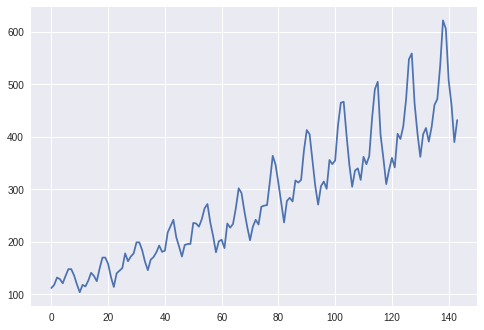

96 48


In [0]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import Input
from keras.layers import merge
from keras.layers import Permute
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import Lambda
from keras.layers import Multiply
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
np.random.seed(7)

# load the dataset
dataset = np.loadtxt('international-airline-passengers.txt')
plt.plot(dataset)
plt.show()
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1,1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

def attention_3d_block(inputs, look_back):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    # a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(look_back, activation='softmax')(a)
    # if SINGLE_ATTENTION_VECTOR:
    #     a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
    #     a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul

def model_lstm(look_back):
    inputs = Input(shape=(look_back, 1))
    lstm_out = LSTM(4, input_shape=(look_back, 1))(inputs)
    output = Dense(1)(lstm_out)
    model = Model(input=[inputs], output=output)
    return model
  
def model_attention_applied_after_lstm(look_back):
    # using the model class API
    inputs = Input(shape=(look_back, 1))
    lstm_out = LSTM(4, input_shape=(look_back, 1), return_sequences=True)(inputs)
    a = Permute((2, 1))(lstm_out)
    a = Dense(look_back, activation='softmax')(lstm_out)
    a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
    a = RepeatVector(4)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    attention_mul = Multiply()([lstm_out, a_probs]) # 
    attention_mul = Flatten()(attention_mul)
    output = Dense(1)(attention_mul) # activation='linear' if not specified
    model = Model(input=[inputs], output=output)
    return model

In [0]:
# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [batch_size (samples?), time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print(trainX.shape)

# create and fit the LSTM network
# model = Sequential()
# model.add(GRU(4, input_shape=(look_back, 1)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)


inputs = Input(shape=(look_back, 1))
lstm_out = LSTM(4, input_shape=(look_back, 1), return_sequences=True)(inputs)
a = Permute((2, 1))(lstm_out)
a = Dense(look_back, activation='softmax')(lstm_out)
a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
a = RepeatVector(4)(a)
a_probs = Permute((2, 1), name='attention_vec')(a)
attention_mul = Multiply()([lstm_out, a_probs])
attention_mul = Flatten()(attention_mul)
output = Dense(1)(attention_mul) # activation='linear' if not specified
#output = Dense(1)(lstm_out)

model = model_lstm(look_back)
# model = Model(input=[inputs], output=output)
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



(91, 4, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Epoch 1/100
 - 1s - loss: 0.0516
Epoch 2/100
 - 0s - loss: 0.0199
Epoch 3/100
 - 0s - loss: 0.0161
Epoch 4/100
 - 0s - loss: 0.0139
Epoch 5/100
 - 0s - loss: 0.0120
Epoch 6/100
 - 0s - loss: 0.0101
Epoch 7/100
 - 0s - loss: 0.0087
Epoch 8/100
 - 0s - loss: 0.0073
Epoch 9/100
 - 0s - loss: 0.0066
Epoch 10/100
 - 0s - loss: 0.0060
Epoch 11/100
 - 0s - loss: 0.0053
Epoch 12/100
 - 0s - loss: 0.0050
Epoch 13/100
 - 0s - loss: 0.0050
Epoch 14/100
 - 0s - loss: 0.0049
Epoch 15/100
 - 0s - loss: 0.0047
Epoch 16/100
 - 0s - loss: 0.0048
Epoch 17/100
 - 0s - loss: 0.0048
Epoch 18/100
 - 0s - loss: 0.0046
Epoch 19/100
 - 0s - loss: 0.0046
Epoch 20/100
 - 0s - loss: 0.0047
Epoch 21/100
 - 0s - loss: 0.0047
Epoch 22/100
 - 0s - loss: 0.0045
Epoch 23/100
 - 0s - loss: 0.0048
Epoch 24/100
 - 0s - loss: 0.0044
Epoch 25/100
 - 0s - loss: 0.0044
Epoch 26/100
 - 0s - loss: 0.0043
Epoch 27/100
 - 0s - loss: 0.0045
Epoch 28/100
 - 0s - loss: 0.0043
Epoch 29/100
 - 0s - loss: 0.0043
Epoch 30/100
 - 0s - lo

Epoch 55/100
 - 0s - loss: 0.0037
Epoch 56/100
 - 0s - loss: 0.0038
Epoch 57/100
 - 0s - loss: 0.0038
Epoch 58/100
 - 0s - loss: 0.0036
Epoch 59/100
 - 0s - loss: 0.0037
Epoch 60/100
 - 0s - loss: 0.0037
Epoch 61/100
 - 0s - loss: 0.0036
Epoch 62/100
 - 0s - loss: 0.0036
Epoch 63/100
 - 0s - loss: 0.0035
Epoch 64/100
 - 0s - loss: 0.0036
Epoch 65/100
 - 0s - loss: 0.0037
Epoch 66/100
 - 0s - loss: 0.0035
Epoch 67/100
 - 0s - loss: 0.0035
Epoch 68/100
 - 0s - loss: 0.0033
Epoch 69/100
 - 0s - loss: 0.0035
Epoch 70/100
 - 0s - loss: 0.0035
Epoch 71/100
 - 0s - loss: 0.0034
Epoch 72/100
 - 0s - loss: 0.0034
Epoch 73/100
 - 0s - loss: 0.0034
Epoch 74/100
 - 0s - loss: 0.0033
Epoch 75/100
 - 0s - loss: 0.0033
Epoch 76/100
 - 0s - loss: 0.0033
Epoch 77/100
 - 0s - loss: 0.0032
Epoch 78/100
 - 0s - loss: 0.0033
Epoch 79/100
 - 0s - loss: 0.0032
Epoch 80/100
 - 0s - loss: 0.0032
Epoch 81/100
 - 0s - loss: 0.0032
Epoch 82/100
 - 0s - loss: 0.0031
Epoch 83/100
 - 0s - loss: 0.0031
Epoch 84/100
 

In [0]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


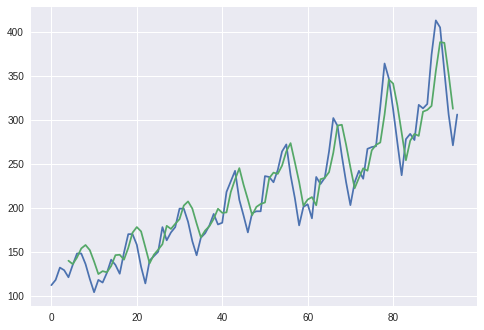

In [0]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset[:int(len(dataset)*0.67)]))
plt.plot(trainPredictPlot[:int(len(dataset)*0.67)])
#plt.plot(testPredictPlot)
plt.show()

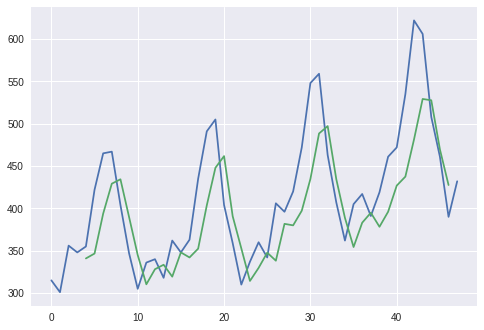

In [0]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset[int(len(dataset)*0.67):]))
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot[int(len(dataset)*0.67):])
plt.show()

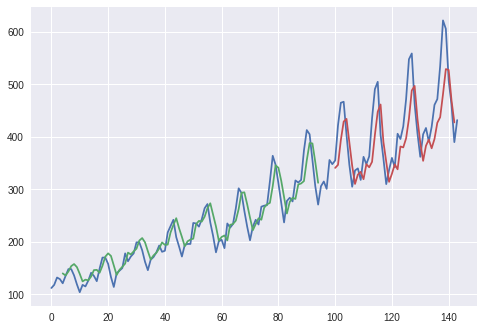

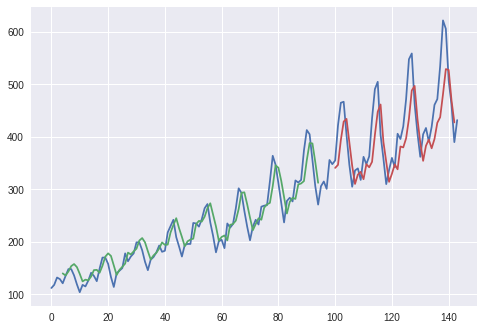

In [0]:

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()